In [8]:
from numpy.core.fromnumeric import amin
import pandas as pd
from read_input import read_pdbs
import itertools
from itertools import product, combinations


native_pdb, fibril_pdb = read_pdbs()

# Make a dictionary from the pdb of resnum:resid from the pdb structure
pdb_resids = native_pdb.residues.resids.tolist()
amino_dict = dict(zip(pdb_resids,(list(native_pdb.residues.resnames))))

# Same dictionary but also with number and names
pdb_resid_name = native_pdb.residues.resnames + '_' + native_pdb.residues.resids.astype(str)
amino_dict_num = dict(zip(pdb_resids,pdb_resid_name))
#print(amino_dict)
#print(amino_dict_num)

# Create the DataFrame of the pairs list
pairs_list = pd.read_csv('GRETA/output_TTR/pairs_list_greta_5.txt', sep='\\s+')

pairs_list.insert(1, 'ai_resnumber', '')
pairs_list.insert(1, 'ai_resname', '')
pairs_list.insert(4, 'aj_resnumber', '')
pairs_list.insert(4, 'aj_resname', '')

# Separation of the atomtype and the aminoacid number. 
# The atomtype column will be replaced avoiding to create a column and delete this one.
pairs_list[['ai_resname', 'ai_resnumber']] = pairs_list.ai.str.split("_", expand = True)
pairs_list[['aj_resname', 'aj_resnumber']] = pairs_list.aj.str.split("_", expand = True)
# Replacing the atomtype values with aminoacid number as int
pairs_list['ai_resname'] = pairs_list['ai_resnumber'].astype(int)
pairs_list['aj_resname'] = pairs_list['aj_resnumber'].astype(int)
# Conversion from str to int
pairs_list['ai_resnumber'] = pairs_list['ai_resnumber'].astype(int)
pairs_list['aj_resnumber'] = pairs_list['aj_resnumber'].astype(int)
# Replacing the aminoacid number with the aminoacid name
pairs_list['ai_resname'] = pairs_list.ai_resname.map(amino_dict)
pairs_list['aj_resname'] = pairs_list.aj_resname.map(amino_dict)

print(pairs_list)#.to_string())


       ai ai_resname  ai_resnumber     aj aj_resname  aj_resnumber  type   c6  \
0    CA_1        TYR             1   CA_1        TYR             1     1 0.01   
1    CA_1        TYR             1   CB_1        TYR             1     1 0.01   
2    CA_1        TYR             1  CB_11        SER            11     1 0.01   
3    CA_1        TYR             1   CB_2        THR             2     1 0.01   
4    CA_1        TYR             1  CD1_1        TYR             1     1 0.00   
..    ...        ...           ...    ...        ...           ...   ...  ...   
901   O_7        LEU             7    O_7        LEU             7     1 0.01   
902   O_7        LEU             7    O_8        SER             8     1 0.01   
903   O_8        SER             8    O_8        SER             8     1 0.01   
904   O_8        SER             8    O_9        PRO             9     1 0.00   
905   O_9        PRO             9    O_9        PRO             9     1 0.01   

     c12  sigma  epsilon  


In [9]:
contacts_histogram = {}
for an in pdb_resids:
    # pdb_resids is the aminocid numbers
    # Selection of the rows contaning the aminoacid number of interest.
    # Note the | and not the &
    is_an = (pairs_list['ai_resnumber'] == an) | (pairs_list['aj_resnumber'] == an)

    # Filtering a dataframe containing only the aminoacid selected.
    pairs_an = pairs_list[is_an]

    print(f'Total amount of contacts made by {amino_dict_num.get(an)}:', len(pairs_an))
    #print(pairs_an)
    pairs_an.loc[pairs_an['ai_resnumber'] == an, 'an_with_who'] = pairs_an['aj_resname'] + '_' + pairs_an['aj_resnumber'].astype(str)
    pairs_an.loc[pairs_an['ai_resnumber'] != an, 'an_with_who'] = pairs_an['ai_resname'] + '_' + pairs_an['ai_resnumber'].astype(str)

    print(pairs_an.to_string())
    an_with_who = pairs_an.an_with_who.value_counts()
    contacts_histogram['{0}'.format(an)] = an_with_who.to_dict()
    print(an_with_who.to_string())

#print(contacts_histogram)

Total amount of contacts made by TYR_1: 189
         ai ai_resname  ai_resnumber      aj aj_resname  aj_resnumber  type   c6  c12  sigma  epsilon an_with_who
0      CA_1        TYR             1    CA_1        TYR             1     1 0.01 0.00   0.42     0.36       TYR_1
1      CA_1        TYR             1    CB_1        TYR             1     1 0.01 0.00   0.43     0.36       TYR_1
2      CA_1        TYR             1   CB_11        SER            11     1 0.01 0.00   0.42     0.36      SER_11
3      CA_1        TYR             1    CB_2        THR             2     1 0.01 0.00   0.41     0.36       THR_2
4      CA_1        TYR             1   CD1_1        TYR             1     1 0.00 0.00   0.38     0.36       TYR_1
5      CA_1        TYR             1   CD2_1        TYR             1     1 0.00 0.00   0.31     0.36       TYR_1
6      CA_1        TYR             1   CE1_1        TYR             1     1 0.00 0.00   0.39     0.36       TYR_1
7      CA_1        TYR             1   CE2_1

In [10]:
# Dataframe preparation

histo_df = pd.DataFrame(contacts_histogram)
histo_df[''] = histo_df.index.astype(str)
histo_df[''] = histo_df[''].str.split('_').str[1].astype(int)
histo_df.sort_values(by = [''], inplace = True)
histo_df.drop(columns='', inplace=True)
histo_df = histo_df.fillna(0)
histo_df.columns = list(amino_dict_num.values())
print(histo_df.to_string())



        TYR_1  THR_2  ILE_3  ALA_4  ALA_5  LEU_6  LEU_7  SER_8  PRO_9  TYR_10  SER_11
TYR_1   68.00  29.00   3.00   0.00   0.00   0.00   0.00   0.00   0.00   35.00   54.00
THR_2   29.00  26.00  28.00   3.00   0.00   0.00   0.00   0.00  10.00   20.00   12.00
ILE_3    3.00  28.00  32.00  24.00   3.00   0.00   0.00  12.00   9.00   15.00    0.00
ALA_4    0.00   3.00  24.00  15.00  14.00   2.00  11.00   0.00   9.00    0.00    0.00
ALA_5    0.00   0.00   3.00  14.00  14.00  25.00  11.00   0.00   0.00    0.00    0.00
LEU_6    0.00   0.00   0.00   2.00  25.00  35.00  42.00   5.00   0.00    0.00    3.00
LEU_7    0.00   0.00   0.00  11.00  11.00  42.00  34.00  22.00   9.00    0.00    2.00
SER_8    0.00   0.00  12.00   0.00   0.00   5.00  22.00  20.00  29.00   19.00   25.00
PRO_9    0.00  10.00   9.00   9.00   0.00   0.00   9.00  29.00  26.00   33.00    7.00
TYR_10  35.00  20.00  15.00   0.00   0.00   0.00   0.00  19.00  33.00   62.00   25.00
SER_11  54.00  12.00   0.00   0.00   0.00   3.00   2.0

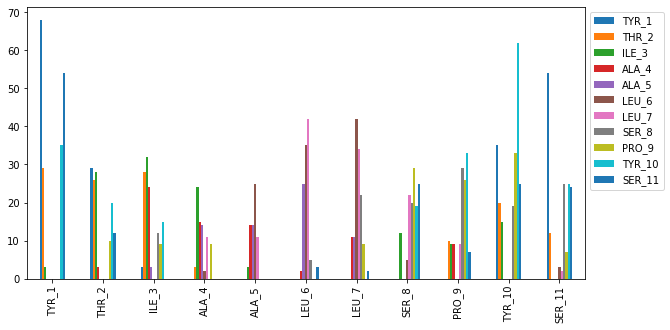

In [11]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib.colors import ListedColormap

histo_df.plot(kind = "bar", stacked = False, figsize = (10,5))
plt.legend(loc = 'upper right', bbox_to_anchor = (1.15, 1))
plt.show()

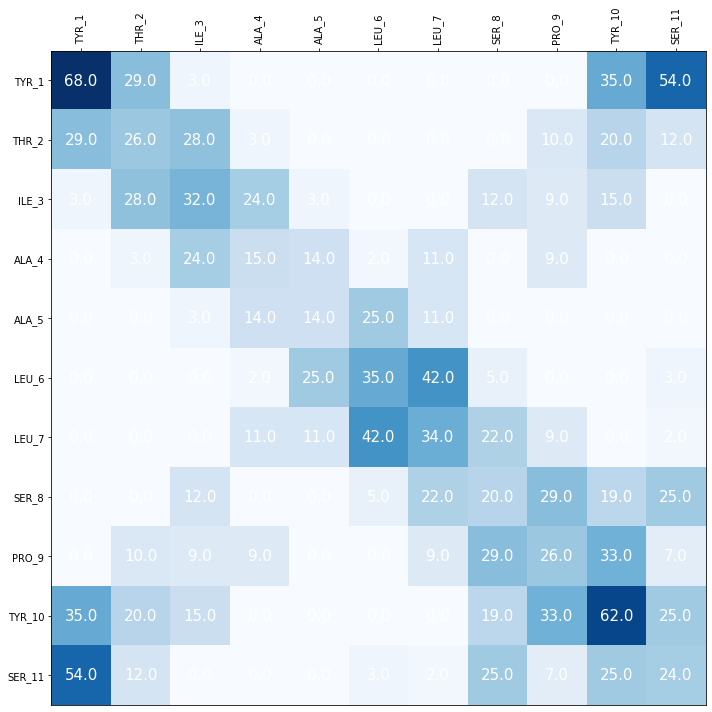

In [12]:
import numpy as np

matrix_df = histo_df.to_numpy()
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(matrix_df, interpolation='nearest', cmap = 'Blues')
# Setting length of the axes to show all the labels 
ax.set_xticks(np.arange(len(histo_df.columns)))
ax.set_yticks(np.arange(len(histo_df.index)))
# Naming all the axis values
ax.set_xticklabels(list(histo_df.columns))
ax.set_yticklabels(list(histo_df.index))
# Rotate x labels
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation = 90, ha='center', rotation_mode='default')

# Loop over data dimensions and create tet annotations
for i in range(len(histo_df.index)):
    for j in range(len(histo_df.columns)):
        text = ax.text(j,i, matrix_df[i,j], ha='center', va='center', color='w', fontsize = 15)
fig.tight_layout()

In [13]:
# Making a normalized dataframe and matrix
histo_df_norm = histo_df.div(histo_df.max().max())
pd.options.display.float_format = '{:.2f}'.format
print(histo_df_norm.to_string())

        TYR_1  THR_2  ILE_3  ALA_4  ALA_5  LEU_6  LEU_7  SER_8  PRO_9  TYR_10  SER_11
TYR_1    1.00   0.43   0.04   0.00   0.00   0.00   0.00   0.00   0.00    0.51    0.79
THR_2    0.43   0.38   0.41   0.04   0.00   0.00   0.00   0.00   0.15    0.29    0.18
ILE_3    0.04   0.41   0.47   0.35   0.04   0.00   0.00   0.18   0.13    0.22    0.00
ALA_4    0.00   0.04   0.35   0.22   0.21   0.03   0.16   0.00   0.13    0.00    0.00
ALA_5    0.00   0.00   0.04   0.21   0.21   0.37   0.16   0.00   0.00    0.00    0.00
LEU_6    0.00   0.00   0.00   0.03   0.37   0.51   0.62   0.07   0.00    0.00    0.04
LEU_7    0.00   0.00   0.00   0.16   0.16   0.62   0.50   0.32   0.13    0.00    0.03
SER_8    0.00   0.00   0.18   0.00   0.00   0.07   0.32   0.29   0.43    0.28    0.37
PRO_9    0.00   0.15   0.13   0.13   0.00   0.00   0.13   0.43   0.38    0.49    0.10
TYR_10   0.51   0.29   0.22   0.00   0.00   0.00   0.00   0.28   0.49    0.91    0.37
SER_11   0.79   0.18   0.00   0.00   0.00   0.04   0.0

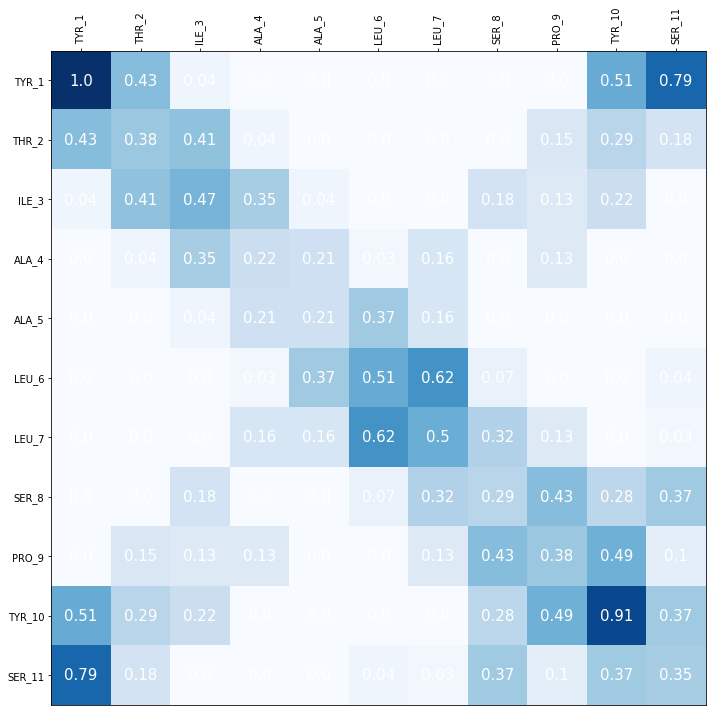

In [14]:
matrix_norm_df = histo_df_norm.to_numpy()
matrix_norm_df = matrix_norm_df.round(decimals = 2)

# plot creation
fig, ax = plt.subplots(figsize = (10,10))
im = ax.imshow(matrix_norm_df, interpolation='nearest', cmap = 'Blues')
# Setting length of the axes to show all the labels 
ax.set_xticks(np.arange(len(histo_df_norm.columns)))
ax.set_yticks(np.arange(len(histo_df_norm.index)))
# Naming all the axis values
ax.set_xticklabels(list(histo_df_norm.columns))
ax.set_yticklabels(list(histo_df_norm.index))
# Rotate x labels
ax.xaxis.tick_top()
plt.setp(ax.get_xticklabels(), rotation = 90, ha='center', rotation_mode='default')

# Loop over data dimensions and create tet annotations
for i in range(len(histo_df_norm.index)):
    for j in range(len(histo_df_norm.columns)):
        text = ax.text(j,i, matrix_norm_df[i,j], ha='center', va='center', color='w', fontsize = 15)
fig.tight_layout()